# DL: Training Stardist and Cellpose Models
- Date: 2022-05-05
- Author: Xingjian Zhang (https://github.com/xjzhaang)

This notebook and the following **DL: Benchmark Table** is part of a small experiment.

The aim is to build a benchmark table for `bioimageloader`'s collection of instance segmentation datasets, using built-in and custom trained models.

In this notebook, we use [StarDist](https://github.com/stardist/stardist) and [Cellpose](https://github.com/mouseLand/cellpose) with `bioimageloader` to train our own models using a combined dataset.

It serves as a demonstration on how you can use `bioimageloader` to do model training. The code blocks can be easily modified to adapt to your own tasks. 

## Changes
- 2022-09-14: Add TissueNet
    - Author: Seongbin Lim (@sbinnee, https://github.com/sbinnee)

# (tmp) Setup

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
gpus

2022-09-14 20:19:23.331641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-14 20:19:24.376168: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-09-14 20:19:24.376930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-14 20:19:24.438119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-14 20:19:24.438153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-14 20:19:24.443301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-14 20:19:24.443346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-09-14 20:19:24.444161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.

In [4]:
# memory growth
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-09-14 20:19:24.459351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 20:19:24.467646: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-14 20:19:24.467960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-14 20:19:24.467981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-14 20:19:24.467997: I tensorflow/stream_executor/platform/default/dso_load

In [5]:
# memory limit
# gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


## 1. StarDist

This tutorial is adapted from the github notebook (https://github.com/stardist/stardist/blob/master/examples/2D/2_training.ipynb)

In [6]:
# %env CUDA_VISIBLE_DEVICES=0
%env TF_CPP_MIN_LOG_LEVEL=3

#Built-in 
import warnings
import logging
import sys

#Ignoring warnings for notebook compilation (might not work)
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)


#Bioimageloader and Albumentation
import albumentations as A
from bioimageloader import Config, BatchDataloader, ConcatDataset
from bioimageloader.transforms import SqueezeGrayImageHWC, HWCToCHW
from bioimageloader.collections import (BBBC020, ComputationalPathology, S_BSST265, 
    DSB2018, FRUNet, BBBC039, BBBC006, Cellpose, LIVECell, TissueNetV1)

#Stardist
from stardist import fill_label_holes, random_label_cmap, calculate_extents
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D
from csbdeep.utils import Path, normalize

# #Cellpose imports
# import torch
# from cellpose import models

#Other imports
#!pip install matplotlib seaborn pandas tqdm numpy
from tqdm.notebook import tqdm
import numpy as np

env: TF_CPP_MIN_LOG_LEVEL=3


### Loading datasets
First, we load our collection of datasets with instance masks together: DSB2018, ComputationalPathology, BBBC006, BBBC020, BBBC039, S_BSST265, FRUNet, Cellpose and LIVECell. 

As each dataset have different numbers of images, we perform data augmentation using `albumentations` library for smaller datasets. We invert the ComPath and LIVECell datasets so they look more like the rest.

The datasets are then combined using `ConcatDataset`.

In [13]:
bbbc020 = BBBC020('./Data/bbbc/020', grayscale=True, image_ch=["nuclei"])
comp = ComputationalPathology('./Data/ComputationalPathology', grayscale=True)
dsb2018 = DSB2018('./Data/DSB2018', grayscale=True, training=True)
sbss = S_BSST265('./Data/BioStudies')
frunet = FRUNet('./Data/FRU_processing')
bbbc006 = BBBC006('./Data/bbbc/006', grayscale=True)
bbbc039 = BBBC039('./Data/bbbc/039')
cellpose = Cellpose('./Data/cellpose', grayscale=True)
livecell = LIVECell('./Data/LIVECell', mask_tif=True, training=True)
tissuenet = TissueNetV1('./Data/tissuenet_1.0/', use_unzipped=True,
                        image_ch=('nuclei',), anno_ch=('nuclei',), uint8=False)

datasets = [bbbc020, comp, dsb2018, sbss, frunet, bbbc006, bbbc039, cellpose,
            livecell, tissuenet]

In [14]:
for dset in datasets:
    print(f'{dset.acronym:12s}: {len(dset):6d}')

BBBC020     :     20
ComPath     :     30
DSB2018     :    670
S_BSST265   :     79
FRUNet      :     72
BBBC006     :    768
BBBC039     :    150
Cellpose    :    540
LIVECell    :   3727
TissueNetV1 :   2601


In [15]:
data = tissuenet[0]

In [18]:
img = data['image']

In [19]:
import cv2

In [21]:
img.shape, img.dtype, img.max()

((512, 512), dtype('float32'), 1.0)

In [22]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [23]:
img_rgb.shape

(512, 512, 3)

In [ ]:
plt.imshow()

In [18]:
import matplotlib.pyplot as plt

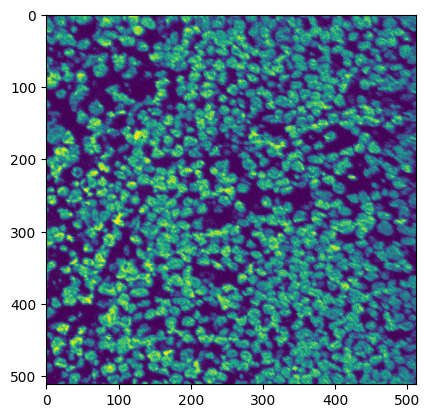

In [19]:
plt.imshow(data['image'])

In [7]:
#Transformations
transforms = A.Compose([
    A.Resize(256, 256),
    SqueezeGrayImageHWC()
])

transforms_compath = A.Compose([
    A.Resize(256, 256),
    A.InvertImg(p=1.0),
    A.OneOf([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
    ], p=0.66),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(p=0.5, limit=80),
    ], p=0.66),
    SqueezeGrayImageHWC()
])

transforms_livecell = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(256,256),
    A.InvertImg(p=1.0),
    SqueezeGrayImageHWC() 
])

transforms_020 = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(256,256),
    A.OneOf([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
    ], p=0.66),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(p=0.5, limit=80),
    ], p=0.66),
    SqueezeGrayImageHWC() 
])

bbbc020 = BBBC020('./Data/bbbc/020', grayscale=True, image_ch=["nuclei"],
                  transforms=transforms_020, num_samples=80)
comp = ComputationalPathology('./Data/ComputationalPathology', grayscale=True,
                              transforms=transforms_compath, num_samples=80)
dsb2018 = DSB2018('./Data/data-science-bowl-2018', grayscale=True, training=True,
                  transforms=transforms, num_samples=80)
sbss = S_BSST265('./Data/BioStudies',
                 transforms=transforms, num_samples=80)
frunet = FRUNet('./Data/FRU_processing',
                transforms=transforms, num_samples=80)
bbbc006 = BBBC006('./Data/bbbc/006', grayscale=True,
                  transforms=transforms, num_samples=80)
bbbc039 = BBBC039('./Data/bbbc/039',
                  transforms=transforms, num_samples=80)
cellpose = Cellpose('./Data/cellpose', grayscale=True,
                    transforms=transforms, num_samples=80)
livecell = LIVECell('./Data/LIVECell', mask_tif=True, training=True,
                    transforms=transforms_livecell, num_samples=80)
tissuenet = TissueNetV1('./Data/tissuenet_1.0/', use_unzipped==True,
                        image_ch=('nuclei',), anno_ch=('nuclei',)
                        transforms=)

dset = ConcatDataset([bbbc020, comp, dsb2018, sbss, frunet,
                      bbbc006, bbbc039, cellpose, livecell])

### Normalization and train/val split
We follow StarDist's sample notebook to perform normalization and train/val split.

In [3]:
X = list()
Y = list()
for d in tqdm(dset):
    X.append(d["image"])
    Y.append(d["mask"])

  0%|          | 0/720 [00:00<?, ?it/s]

In [4]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]


assert len(dset) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(dset))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

- training:       612
- validation:     108


### Initialize a stardist model

In [5]:
#Default parameters used in Stardist's own example notebook
n_rays = 32
grid = (2,2)
conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = True,
    n_channel_in = 1,
)

#Specify the name and directory of the model
model = StarDist2D(conf, name='stardist_model_1', basedir='stardist_models')


median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

Using default values: prob_thresh=0.5, nms_thresh=0.4.
median object size:      [16. 13.]
network field of view :  [94 93]


### Training and optimization

In [7]:
#We train then optimize the thresholds of a stardist model using the default parameters. 
#Epochs is set to 1 for demonstration
model.train(X_trn, Y_trn, validation_data=(X_val, Y_val), epochs=1)
model.optimize_thresholds(X_val, Y_val)

100/100 [==============================] - 9s 93ms/step - loss: 1.4590 - prob_loss: 0.3824 - dist_loss: 5.3832 - prob_kld: 0.2577 - dist_relevant_mae: 5.3827 - dist_relevant_mse: 72.6304 - dist_dist_iou_metric: 0.2540 - val_loss: 1.3347 - val_prob_loss: 0.3480 - val_dist_loss: 4.9334 - val_prob_kld: 0.2275 - val_dist_relevant_mae: 4.9328 - val_dist_relevant_mse: 63.9465 - val_dist_dist_iou_metric: 0.2826

Loading network weights from 'weights_best.h5'.


NMS threshold = 0.5:  75%|████▌ | 15/20 [01:24<00:28,  5.62s/it, 0.199 -> 0.015]


Using optimized values: prob_thresh=0.198454, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.19845443151963815, 'nms': 0.3}

## 2. Cellpose

### Loading datasets


We follow the same procedures as StarDist, except here we use `HWCToCHW` (explained in the previous notebook).

In [ ]:
#Transformations
transforms = A.Compose([
    A.Resize(256, 256),
    HWCToCHW() 
])

transforms_compath = A.Compose([
    A.Resize(256, 256),
    A.InvertImg(p=1.0),
    A.OneOf([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
    ], p=0.66),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(p=0.5, limit=80),
    ], p=0.66),
    HWCToCHW()
])

transforms_livecell = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(256,256),
    A.InvertImg(p=1.0),
    HWCToCHW()
])

transforms_020 = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(256,256),
    A.OneOf([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
    ], p=0.66),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(p=0.5, limit=80),
    ], p=0.66),
    HWCToCHW()
])

bbbc020 = BBBC020('./Data/bbbc/020', grayscale=True, image_ch=["nuclei"],
                  transforms=transforms_020, num_samples=80)
comp = ComputationalPathology('./Data/ComputationalPathology', grayscale=True,
                              transforms=transforms_compath, num_samples=80)
dsb2018 = DSB2018('./Data/data-science-bowl-2018', grayscale=True, training=True,
                  transforms=transforms, num_samples=80)
sbss = S_BSST265('./Data/BioStudies',
                 transforms=transforms, num_samples=80)
frunet = FRUNet('./Data/FRU_processing',
                transforms=transforms, num_samples=80)
bbbc006 = BBBC006('./Data/bbbc/006', grayscale=True,
                  transforms=transforms, num_samples=80)
bbbc039 = BBBC039('./Data/bbbc/039',
                  transforms=transforms, num_samples=80)
cellpose = Cellpose('./Data/cellpose', grayscale=True,
                    transforms=transforms, num_samples=80)
livecell = LIVECell('./Data/LIVECell', mask_tif=True, training=True,
                    transforms=transforms_livecell, num_samples=80)

dset = ConcatDataset([bbbc020, comp, dsb2018, sbss, frunet,
                      bbbc006, bbbc039, cellpose, livecell])

In [ ]:
X = list()
Y = list()
for d in tqdm(dset):
    X.append(d["image"])
    Y.append(d["mask"])

### Train/val split
For Cellpose, we do not need to normalize the data before training, it is done by specifying `normalize = True` in the training parameters.

In [ ]:
assert len(dset) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(dset))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

### Initialize model and train

In [ ]:
#We set n_epochs = 1 for demonstration
model = models.CellposeModel(pretrained_model=None, diam_mean=15, gpu=True)
model.train(train_data=X_trn, train_labels=Y_trn, train_files=None,
            test_data=X_val, test_labels=Y_val, test_files=None,
            normalize = True, 
            channels = [0,0],
            save_path='cellpose_models',
            save_every=1,
            learning_rate=0.01,
            n_epochs=1,
            momentum=0.9,
            weight_decay=0.00001,
            batch_size=32)